**Librerias**

In [1]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import resample
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import argrelextrema

**Funciones**

In [2]:
#Se encarga de extraer para un archivo WFDB dado, el canal específico que incluye
#el vector de datos de la derivación y las anotaciones

#Retorna vector, anotaciones, longitud_muestras

def extrear_derivacion(filename, canal):
    # Leer el archivo de registro y sus anotaciones
    record = wfdb.rdrecord(filename)
    annotation = wfdb.rdann(filename, 'atr') # Cambia 'atr' por la extensión de las anotaciones si es diferente

    # Seleccionar la derivación específica y sus anotaciones correspondientes
    lead_number = canal  # Cambia este número por el índice de la derivación deseada (0 para la primera, 1 para la segunda, etc.)

    selected_lead = record.p_signal[:, lead_number]
    selected_annotation_indices = [i for i in range(len(annotation.sample)) if annotation.chan[i] == lead_number]
    selected_annotations = annotation.sample[selected_annotation_indices]
    selected_symbols = [annotation.symbol[i] for i in selected_annotation_indices]
    selected_aux_note = [annotation.aux_note[i] for i in selected_annotation_indices]

    # Crear un nuevo objeto de registro y anotaciones con solo la derivación deseada y sus anotaciones
    selected_record = wfdb.Record(record_name=record.record_name, fs=record.fs, n_sig=1,
                                  sig_len=len(selected_lead), p_signal=selected_lead.reshape(-1, 1),
                              units=[record.units[lead_number]], sig_name=[record.sig_name[lead_number]])

    selected_annotation = wfdb.Annotation(record_name=annotation.record_name, extension=annotation.extension,
                                      sample=selected_annotations, symbol=selected_symbols,
                                      aux_note=selected_aux_note, chan=[0] * len(selected_annotations),
                                      num=len(selected_annotations), fs=annotation.fs)

    
    # Longitud en número de muestras de cada señal
    signal_length = record.sig_len

    return selected_record, selected_annotation, signal_length

In [3]:
#Permite graficar el contenido del vector y anotación, para un intervalo de tiempo en segundos
#especificado como start_time, end

def graficar(rec, ann, start_time, end):
    # Define el intervalo de tiempo en segundos que deseas graficar
    # Convertir los tiempos a índices
    start_index = int(start_time * rec.fs)
    end_index = int(end * rec.fs)

    # Acotar el intervalo de tiempo de la señal y las anotaciones
    time = np.arange(start_index, end_index) / rec.fs
    signal = rec.p_signal[start_index:end_index]
    ann_indices = (ann.sample >= start_index) & (ann.sample < end_index)
    ann_sample = ann.sample[ann_indices] - start_index
    ann_symbol = np.array(ann.symbol)[ann_indices]

    # Graficar la señal y las anotaciones
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(time, signal)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f"{rec.sig_name[0]} ({rec.units[0]})")

    for s, x in zip(ann_symbol, ann_sample):
        ax.annotate(s, xy=((x / rec.fs) + start_time, signal[x]), xycoords='data', textcoords='data',
                    arrowprops=dict(facecolor='red', arrowstyle="wedge,tail_width=0.7", alpha=0.8),
                    fontsize=12, color='red', alpha=0.8)

    plt.show()

In [4]:
def process_ecg_signal2(rec, ann, segment_length=10, multiplier=1.2, new_fs=125, new_length=187):
    fs = rec.fs
    segment_samples = segment_length * fs
    n_segments = rec.sig_len // segment_samples
    p_signal = rec.p_signal

    segments = []
    labels = []
    periodo = []
    segments_ = []

    for i in range(n_segments):
        start_sample = i * segment_samples
        end_sample = (i + 1) * segment_samples

        # Extraer y normalizar el segmento de 10 segundos
        segment = p_signal[start_sample:end_sample]
        normalized_segment = (segment - np.min(segment)) / (np.max(segment) - np.min(segment))

        # Encontrar las anotaciones y calcular T dentro del segmento de 10 segundos
        ann_indices = (ann.sample >= start_sample) & (ann.sample < end_sample)
        ann_sample = ann.sample[ann_indices] - start_sample
        ann_symbol = np.array(ann.symbol)[ann_indices]
        T = np.mean(np.diff(ann_sample))
        
        periodo.append(T*multiplier)

        # Iterar las anotaciones en el segmento de 10 segundos
        for j, (s, x) in enumerate(zip(ann_symbol, ann_sample)):
            # Extraer T*1.2 muestras a la derecha a partir de la posición de la anotación
            #start_subsample = x -5
            #end_subsample = min(x -5 + int(T * multiplier), end_sample - start_sample)
            
            start_subsample = x - int(T*0.5)
            end_subsample = min(x + int(T*0.7), end_sample - start_sample)
            
            subsegment = normalized_segment[start_subsample:end_subsample]

            # Rellenar con ceros hasta 1600 muestras
            subsegment_400 = np.zeros(1600)
            subsegment_400[:len(subsegment.flatten())] = subsegment.flatten()


            # Remuestrear a 125 Hz y interpolar para obtener un vector de longitud 187
            #subsegment_125 = resample(subsegment_360, int(fs/new_fs * len(subsegment_360)))
            #f = interp1d(np.linspace(0, 1, num=len(subsegment_125)), subsegment_125, kind='cubic')
            #subsegment_out = f(np.linspace(0, 1, num=new_length))

            segments.append(subsegment_400)
            segments_.append(subsegment)
            
            labels.append(s)

    return segments, labels, periodo, segments_


In [5]:
def plot_filtered_segments(segments, labels, target_label, num_to_plot, file):
    filtered_segments = [seg for seg, label in zip(segments, labels) if label == target_label]

    fig, ax = plt.subplots(figsize=(6, 4))
    for i in range(min(num_to_plot, len(filtered_segments))):
        ax.plot(filtered_segments[i])

    ax.set_ylabel('Amplitud normalizada')
    ax.set_xlabel('Muestras de ' + file)
    #ax.legend(loc='upper right')
    #plt.tight_layout()
    plt.show()




In [6]:
def resample_vector(vector, old_fs, new_fs):
    segment_resample = vector;

    # Definir la frecuencia de muestreo original y la deseada
    frecuencia_original = 250
    frecuencia_deseada = 125

    # Calcular el factor de reescalado
    factor_reescalado = frecuencia_original / frecuencia_deseada

    # Remuestrear los datos
    #datos_125Hz = np.resample(datos_1000Hz, int(len(datos_1000Hz)/factor_reescalado))

    #new_fs = 125 # Nueva frecuencia de muestreo
    for i in range(len(segment_resample)):
        #new_length = int(187 * new_fs / 360)
        subsegment_125 = resample(segment_resample[i], int(len(segment_resample[i])/factor_reescalado))
        segment_resample[i] = subsegment_125[:187]
        
    return segment_resample


In [7]:
def padding(lista):
    segments_padded = []
    desired_length = 187

    for segment in lista:
        # obtener la longitud actual del segmento
        current_length = len(segment)

        # calcular la cantidad de ceros que se necesitan agregar
        n_zeros = desired_length - current_length

        # agregar los ceros al final del segmento
        padded_segment = np.pad(segment, (0, n_zeros), 'constant')

        # agregar el segmento acolchado a la lista
        segments_padded.append(padded_segment)
        
    return segments_padded


In [19]:
def procesar(guardarComo, file, muestras, tipo, factor, periodo_maximo = False, grafica_periodo = False, graficas_tipo = False):
    filename = './dataset/dataset-modelo/'+file
    rec, ann, longitud = extrear_derivacion(filename, 0)
    segments, labels, periodo, analizar = process_ecg_signal2(rec, ann, 10, factor)
    per_maximo = 0
    
    if grafica_periodo == True:
        plt.plot(periodo)
        plt.show()
    
    if periodo_maximo == True:
        #print("Periodo máximo: ", max(periodo))
        per_maximo = max(periodo)
    
    segments_resample = resample_vector(segments, 360, 125)
    
    #segmento_ajustado = padding(segments_resample)
    
    if graficas_tipo == True:
        label_counts = Counter(labels)
        print("Conteo de etiquetas:", label_counts)
    
        target_label = tipo  # Cambia esto por la etiqueta que deseas filtrar
        num_to_plot = muestras     # Cambia esto por la cantidad de segmentos que deseas graficar
        plot_filtered_segments(segments_resample, labels, target_label, num_to_plot, file)
    
    # Crear un DataFrame a partir de la lista 'segmentos'
    df = pd.DataFrame(segments_resample)

    # Agregar una nueva columna con las etiquetas en la lista 'etiquetas'
    df['etiqueta'] = labels

    # Guardar el DataFrame inicial en un archivo CSV
    df.to_csv(guardarComo, mode='a', index=False, header=False)
    
    return df, per_maximo


In [9]:
def lista(num_inicial, num_final):
    # Generar una lista de cadenas de 3 dígitos
    numeros = [str(i) for i in range(num_inicial, num_final+1)]

    return numeros


In [10]:
def reetiquetado(df):
    # Crear un diccionario de mapeo para agrupar las categorías
    mapeo_categorias = {
        'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
        'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
        'V': 'V', 'E': 'V', 'F': 'V',
        'F': 'F',
        '/': 'Q', 'f': 'Q', 'Q': 'Q'
    }

    # Aplicar el mapeo de categorías a la columna 188
    df[187] = df[187].map(mapeo_categorias)

    return df

In [11]:
def etiqueta_numerica(df):
    # Diccionario de mapeo de etiquetas a números
    mapeo_numerico = {
        'N': 0,
        'Q': 4,
        'V': 2,
        'S': 1,
        'F': 3
    }

    # Aplicar el mapeo de etiquetas a números a la columna '188'
    df[187] = df[187].map(mapeo_numerico)

    return df

In [12]:
def proporcion_ceros(fila):
    total_ceros = sum(fila == 0)
    total_elementos = len(fila)
    return total_ceros / total_elementos


### **Análisis exploratorio**

En Kaggle existe un dataset con segmentos de latidos ya preprocesados con el cual han desarrollado modelos de buenos resultados utilizando su conjunto de datos de prueba.

![imagen.png](https://drive.google.com/uc?export=view&id=11Tvea6r7jXTOUneG9rikO0lD8D36Fj7l)

En una primer aproximación, se utilizó este dataset que ya no requirió un trabajo de exploración. 

Sin embargo, el reto era sementar los latidos con el mismo criterio para ser evaluados por el modelo. Este punto fue problemático, ya que ligeras variaciones en la manera de segmentar, se traducia en resultados con una alta variabilidad en la clasificación de los latidos.

Derivado de lo anterior, se optó por partir de la base de datos original de Physionet indentificada como "MIT-BIH Arrhythmia Database" disponible en https://www.physionet.org/content/mitdb/1.0.0/

Esta información tiene las siguientes características generales:

- 48 extractos de media hora de registro de ECG
- La información pertenece a 47 personas diferentes
- Las grabaciones contienen trazos con una frecuencia de muestreo de 360Hz
- Aproximadamente 110,000 anotaciones totales

**Definir la ventana de segmentación**

El primer paso es determinar el ancho de la ventana de segmentación. El dataset de Kaggle estableció una ventana de 187 muestras, para trazos de 125 Hz.

Comenzamos por explorar todos los archivos en bloques de 10segundos. 

La regla de 10 segundos se toma como referencia de la práctica implementada por el algoritmo de Philips DXL para analizar 12 derivaciones. Philips para obtener métricas, obtiene todos los latidos que existan en un vector de 10 segundos. Eso le permite obtener un latido sintético representativo a los 10 segundos sobre el cual extraer características.

Siendo así, se procede a analizar cada uno de los archivos en segmentos de 10 segundos y obteniendo la media de la frecuencia cardiaca en cada segmento. 


In [13]:
#construimos la lista con los 48 archivos
lista_archivos = lista(100,109) + lista(111,119) + lista(121,124) + \
        lista(200,203) + ['205'] + lista(207,210) + lista(212,215) + \
        ['217'] + lista(219,223) + ['228'] + lista(230,234)

print('Total de archivos: ', len(lista_archivos))

Total de archivos:  48


In [20]:
#definimos un nombre de salida para los datos analizados
analizar_periodo = 'analizar_periodo.csv'

#iteramos la lista de archivos extrayendo el periodo
periodo_max = []
for f in lista_archivos:
    _, periodo_maximo = procesar(analizar_periodo, f, 50, 'N', 1.2, periodo_maximo=True)
    periodo_max.append(periodo_maximo)

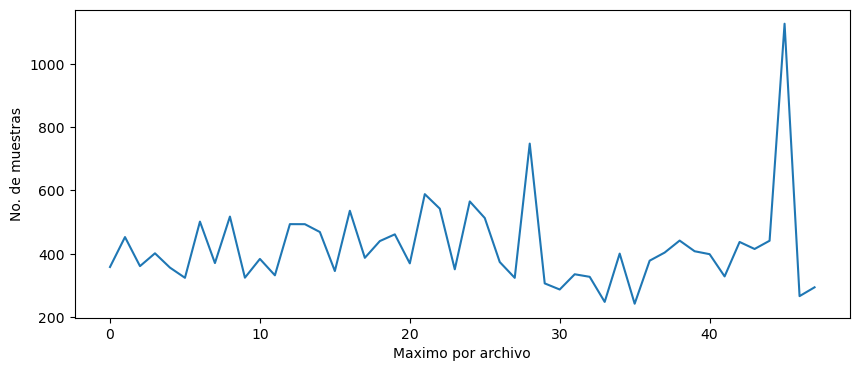

In [21]:
plt.figure(figsize=(10,4))
plt.plot(periodo_max)
plt.ylabel('No. de muestras')
plt.xlabel('Maximo por archivo')
plt.show()

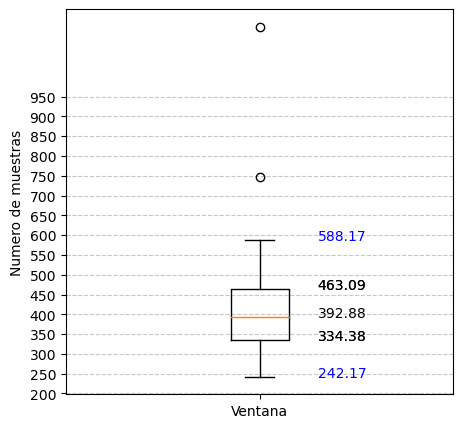

In [22]:
#Analizamos la información de los periodos

plt.figure(figsize=(5,5))
bp = plt.boxplot(periodo_max)
# Configurar título y etiquetas
plt.title('')
plt.ylabel('Numero de muestras')
plt.xticks([1], ['Ventana'])
y_ticks = np.arange(200, 1000, 50)
plt.yticks(y_ticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Dibujar los valores de los cuartiles
for i, box in enumerate(bp['boxes']):
    whisker_bottom = bp['whiskers'][2 * i].get_ydata()[1]
    whisker_top = bp['whiskers'][2 * i + 1].get_ydata()[1]
    y_bottom = box.get_ydata()[0]
    y_top = box.get_ydata()[2]
    Q1 = box.get_ydata()[1]
    Q3 = box.get_ydata()[3]
    median = bp['medians'][i].get_ydata()[0]

    # Dibujar valores
    plt.text(i + 1.15, whisker_bottom, f"{whisker_bottom:.2f}", fontsize=10, color='blue')
    plt.text(i + 1.15, whisker_top, f"{whisker_top:.2f}", fontsize=10, color='blue')
    plt.text(i + 1.15, y_bottom, f"{y_bottom:.2f}", fontsize=10)
    plt.text(i + 1.15, y_top, f"{y_top:.2f}", fontsize=10)
    plt.text(i + 1.15, Q1, f"{Q1:.2f}", fontsize=10)
    plt.text(i + 1.15, Q3, f"{Q3:.2f}", fontsize=10)
    plt.text(i + 1.15, median, f"{median:.2f}", fontsize=10)
    
plt.show()

In [23]:
#Lo anterior indica que dejando fuera los valores atípicos, deberíamos considerar 588.17 muestras
tiempo = 588.17 * (1/360)
print("Ventana de: ", tiempo,"segundos")

Ventana de:  1.6338055555555555 segundos


In [24]:
#ahora, considerando un muestreo de 125 Hz, el número de muestras a considerar es de:
muestras = tiempo * 125
print("Ventana de muestras: ", muestras)

Ventana de muestras:  204.22569444444443


Lo anterior explica el porqué diferentes artículos que utilizan el dataset de Physionet, establecen una longitud de vector de 187 muestras.

Para efectos del proyecto, tomaremos igualmente 187 muestras. En un próximo ejercicio, se tomarán las 204 que se calcularon y se compararán los resultados.


## **¿Por qué ajustar la frecuencia a 125Hz?**

Consultando la literatura y encontrando un número importante de trabajos que abordan este problema con redes neuronales convolucionales (CNN), la justificación es la siguiente:

- Eficiencia computacional: Al disminuir la frecuencia de muestreo, el volumen de datos a procesar y almacenar se reduce significativamente. Para expertos en aprendizaje profundo y big data, esta reducción puede ser crucial para acelerar el tiempo de entrenamiento y limitar los requisitos de almacenamiento, especialmente cuando se trabaja con grandes volúmenes de datos y modelos complejos como las CNN.
- Filtrado de ruido y mejoramiento de señal: Al reducir la frecuencia de muestreo, se eliminan las componentes de alta frecuencia, lo que también puede eliminar el ruido no deseado en las señales de ECG, como artefactos musculares y otros factores no cardíacos. Esto facilita la identificación y extracción de características relevantes del ECG por parte de las CNN, lo que puede mejorar la precisión del modelo y su capacidad para generalizar.
- Reducción de dimensionalidad y prevención del sobreajuste: La disminución de la frecuencia de muestreo conlleva una reducción en la dimensionalidad de los datos. Esto simplifica los modelos de CNN y disminuye el riesgo de sobreajuste, lo que es especialmente relevante en contextos de aprendizaje profundo donde se manejan grandes cantidades de parámetros. Además, la reducción de dimensionalidad facilita la visualización y el análisis de los datos, lo que puede ser útil para comprender mejor el rendimiento del modelo y la importancia de las características extraídas.

Es por lo anterior, que la base de datos de Physionet se ajustará de 360Hz a 125Hz para el modelo de entrenamiento.

## **Salida que se espera de los latidos**

![imagen.png](https://drive.google.com/uc?export=view&id=1-CEOs2bgnpMux12-FrOYnca73rz14Ghc)

## **Proceso para segmentar el datset de Physionet**

https://physionet.org/content/mitdb/1.0.0/

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

**Crea la lista con los nombres de los archivos originales del dataset**

Se crea una lista con los nombre de todos los archivos que se descargaron
como base de datos de trazos de ECG

In [ ]:
lista_archivos = lista(100,109) + lista(111,119) + lista(121,124) + \
        lista(200,203) + ['205'] + lista(207,210) + lista(212,215) + \
        ['217'] + lista(219,223) + ['228'] + lista(230,234)
print(lista_archivos)


**Extracción de los segmentos de latidos**

In [ ]:
#definimos el nombre del archivo en donde se van a integrar 
#todos los segmentos que se extraen de la base de datos

dataset_guardar = 'borrar.csv'

**Metdología para el preprocesamiento de la base de datos**

a) Se selecciona el archivo de la base de datos Physionet MIT-BIH Arrhythmia.

b) El archivo puede contener más de una derivación, por lo que selecciona la Derivación II que proporciona la información más relevente del trazo de ECG. El vector que se extrae es de tipo "record" junto con un vector tipo "annotation", que tiene las etiquetas generadas por los cardiólogos que revisaron el archivo.

La siguiente imagen muestra un ejemplo del contenido de un archivo de la base de datos.

![imagen.png](https://drive.google.com/uc?export=view&id=1GH2cdOaMKXhNjJzKA5reQ5f6g9XhKOH-)

c) Se recorrerá el archivo extrayendo bloques de 10 segundos de información.

d) El bloque de 10 segundos se normaliza entre valores 0 y 1

e) Utilizando las anotaciones generadas por los cardiólogos en cada uno de los latidos, se calcula la media de la frecuencia cardiaca en los 10 segundos. Esta frecuencia media, se utilizará como la ventana para segmentar un latido. Es decir, de la posicion del latido, se tomara ventana * 0.5 muestras a la izquierda y ventana * 0.7 muestras a la derecha. La proporción obedece a la distribución característica de un latido de corazón.

f) Se tomarán solamente los latidos que cumplan con su ventana de datos completa. Esto es, posiblemente algunos latidos que se encuentren en los extremos izquierda y derecha, podrán quedar excluidos por no tener información completa.

g) Se extraerán los N latidos que se identifiquen en el bloque de 10 segundos, utilizando las posiciones de las etiquetas hechas por los cardiólogos. 

h) Cada uno de los latidos que se extraen, fueron generados a 360Hz. Para simplificar la cantidad de datos, se baja el muestreo a 125Hz, que permite continuar manteniendo las características relevantes de la morfología del latido.

i) En la diversidad de estudios de la base de datos, existen diferentes frecuencias cardiacas de los pacientes. Esto significa, que la frecuencia media que se calculó en el paso e) arrojará una ventana de datos que puede ir desde unas 75 muestras (frecuencia cardiaca alta) hasta poco más de 175 muestras (frecuencia cardiaca baja). Por ello se estandariza una longitud de vector a 187 muestras para todos los latidos.

A continuación se muestran ejemplos del resultado de la segmentación de diferentes archivos, mostrando un grupo de latidos de tipo 'N'. Esta clase se explica en el punto k)

![imagen.png](https://drive.google.com/uc?export=view&id=1ZaQFZ8zoiy9-hkWt5nur_EXCiPTNvXwy)

![imagen.png](https://drive.google.com/uc?export=view&id=1jcyNprh_K8ZwLoDNH6vwXvbDocWx0xBD)


![imagen.png](https://drive.google.com/uc?export=view&id=17qK3Qnll-YCMLSg9g32eXsABdvcmSFVV)


![imagen.png](https://drive.google.com/uc?export=view&id=1oWo_eo00y_awKES-6DCuRE0tYbMNpwrt)


j) Para cada uno de los latidos que se segmentó, se unifica la longitud de 187 muestras rellenando con ceros los datos faltantes. Esto para no influir en la morfología del trazo.

k) Cada uno de los latidos segmentados, se etiqueta con la anotación que generaron los cardiólogos (MIT-BIH Class) que indica un tipo de latido específico.

![imagen.png](https://drive.google.com/uc?export=view&id=13ZmZhK3_Ww5AFtWn_eujbFSSRW034sv7)

l) Lo anterior nos arrojará un dataset de latidos segmentados con hasta 15 posibles clases de latidos.

m) Hasta aquí, ha quedado un dataset de las siquientes características.

Total de latidos segmentados: 112,299

Clases de latidos encontrados y cantidades: 

'N': 74804, 'L': 8055, 'R': 7241, 'V': 7116, '/': 7005, 'A': 2530, '+': 1289, 'f': 979, 'F': 802 , '~': 615, '!': 472, '"': 437, 'j': 229, 'x': 192, 'a': 149, '|': 132, 'E': 106, 'J': 83, 'Q': 33, 'e': 16, '[': 6, ']': 6, 'S': 2

In [ ]:
# se implementa un for para recorrer cada uno de los archivos
#disponibles

for f in lista_archivos:
    procesar(dataset_guardar, f, 200, 'N', 1.2, graficas_tipo=True)
    
#A continuación se muestra un extracto de 50 latidos de tipo 'N' para 
#cada uno de los archivos que se han procesado. 
#Los que están en blanco, significa que ese archivo no tiene latidos de la clase 'N'

**Se inicia con la limpieza del dataset**

In [ ]:
#se cargan los latidos segmentados
segmentos = pd.read_csv(dataset_guardar, header=None)

In [ ]:
print(segmentos.shape)

In [ ]:
etiquetas = segmentos.iloc[:, -1]

In [ ]:
label_counts = Counter(etiquetas)
print("Conteo de etiquetas:", label_counts)

**Agrupación para 5 clases**

Se procede con la agrupación de las clases MIT-BIH Class en las 5 clases AAMI que son 'N', 'S', 'V', 'F', 'Q'

**Se realiza el cambio de etiquetas*

![imagen.png](https://drive.google.com/uc?export=view&id=13ZmZhK3_Ww5AFtWn_eujbFSSRW034sv7)

In [ ]:
segmentos_etiq = reetiquetado(segmentos)
etiquetas2 = segmentos_etiq.iloc[:, -1]
label_counts = Counter(etiquetas2)
print("Conteo de etiquetas:", label_counts)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

#Clase 0 : 86846
#Clase 1 : 2647
#Clase 2 : 6976
#Clase 3 : 785
#Clase 4 : 7702
    
# Tus datos
etiquetas2 = ['N'] * 86846 + ['Q'] * 7702 + ['V'] * 6976 + ['S'] * 2647 + ['F'] * 785
#etiquetas2 = ['N'] * 90345 + ['Q'] * 8017 + ['V'] * 7222 + ['S'] * 2764 + ['F'] * 802 + ['na'] * 3149
label_counts = Counter(etiquetas2)
print("Conteo de etiquetas por clase:", label_counts)

# Extraer etiquetas y conteos
labels, counts = zip(*label_counts.items())

# Crear gráfico de barras
bars = plt.bar(labels, counts)

# Configurar título y etiquetas de los ejes
plt.title('Conteo de Etiquetas')
plt.xlabel('Clases AAMI')
plt.ylabel('Etiquetas')

# Agregar valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 500, str(height), ha='center', va='bottom')

# Mostrar el gráfico
plt.show()

**Se eliminan las nan**

In [ ]:
segmentos_etiq = segmentos_etiq.dropna(subset=[187])

In [ ]:
etiquetas2 = segmentos_etiq.iloc[:, -1]

In [ ]:
label_counts = Counter(etiquetas2)
print("Conteo de etiquetas:", label_counts)

**Cambio de la etiqueta string por la codificación numérica**

Se realizará el cambio de etiquetas como sigue:
    
['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [ ]:
segmentos_etiq = etiqueta_numerica(segmentos_etiq)

In [ ]:
etiquetas2 = segmentos_etiq.iloc[:, -1]
label_counts = Counter(etiquetas2)
print("Conteo de etiquetas:", label_counts)

**Revisa las filas con mayoria en ceros**

Se han  identificado que algunas filas de los latidos segmentados, son mayormente ceros. Estos segmentos no son representativos de un latido, por lo que se eliminarán del dataset.

El criterio para eliminarlos es si más del 90% de las 187 columnas tienen ceros,

In [ ]:
segmentos_etiq['proporcion_ceros'] = segmentos_etiq.iloc[:, :-1].apply(proporcion_ceros, axis=1)


In [ ]:
umbral_ceros = 0.9
segmentos_ceros = segmentos_etiq[segmentos_etiq['proporcion_ceros'] > umbral_ceros]


In [ ]:
#Se verifica el número de filas con ceros
segmentos_ceros.shape

In [ ]:
#se corrobora que el filtro haya sido correcto
segmentos_ceros

**Removemos las filas con ceros**

In [ ]:
umbral_ceros = 0.9
segmentos_etiq = segmentos_etiq[segmentos_etiq['proporcion_ceros'] <= umbral_ceros]
segmentos_limpios = segmentos_etiq.drop(columns=['proporcion_ceros'])

In [ ]:
segmentos_limpios.shape

In [ ]:
#conteo de etiquetas después de eliminar los ceros
y_limpio = segmentos_limpios.iloc[:, -1]

clases_train = np.bincount(y_limpio)
print(f"Clase 0 : {clases_train[0]}")
print(f"Clase 1 : {clases_train[1]}")
print(f"Clase 2 : {clases_train[2]}")
print(f"Clase 3 : {clases_train[3]}")
print(f"Clase 4 : {clases_train[4]}")

**Salvamos el dataset depurado para el entrenamiento del modelo**

In [ ]:
segmentos_limpios.to_csv('ds_depurado_mit_bih.csv', index=False, header=False)